In [1]:
!pip install git+https://github.com/brianbt/btorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-ps46qpij
  Running command git clone -q https://github.com/brianbt/btorch /tmp/pip-req-build-ps46qpij


In [2]:
import torch
from tqdm import tqdm
import pandas as pd

# Btorch
import btorch
from btorch import nn
import btorch.nn.functional as F

# Create Model

In [3]:
class Net(nn.Module):
    def __init__(self, classes):
        super(Net, self).__init__()
        self.a_a_1 = nn.Linear(100, 100)
        self.a_a_2 = nn.Linear(100, 100)
        self.a_b_1 = nn.Linear(100, 100)
        self.b_a_1 = nn.Linear(100, 100)
        self.c_a = nn.Linear(100, 100)
        self.c_1 = nn.Linear(100, 100)
        self.c_2 = nn.Linear(100, 100)
        self.d = nn.Linear(100, 100)
        self.e = nn.Linear(100, 100)
        self.f = nn.Linear(100, 100)
        self.g = nn.Linear(100, 100)
        self.final = nn.Linear(100, classes)
    def forward(self, x):
        x = self.a_a_1(x)
        x = self.a_a_2(x)
        x = self.b_a_1(x)
        x = self.c_a(x)
        x = self.c_1(x)
        x = self.c_2(x)
        x = self.d(x)
        x = self.e(x)
        x = self.f(x)
        x = self.g(x)
        x = self.final(x)
        return x

Let create a Modela and see how it looks like

In [4]:
model = Net(3)
model

Net(
  (a_a_1): Linear(in_features=100, out_features=100, bias=True)
  (a_a_2): Linear(in_features=100, out_features=100, bias=True)
  (a_b_1): Linear(in_features=100, out_features=100, bias=True)
  (b_a_1): Linear(in_features=100, out_features=100, bias=True)
  (c_a): Linear(in_features=100, out_features=100, bias=True)
  (c_1): Linear(in_features=100, out_features=100, bias=True)
  (c_2): Linear(in_features=100, out_features=100, bias=True)
  (d): Linear(in_features=100, out_features=100, bias=True)
  (e): Linear(in_features=100, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=100, bias=True)
  (g): Linear(in_features=100, out_features=100, bias=True)
  (final): Linear(in_features=100, out_features=3, bias=True)
)

In [5]:
from btorch.utils.trainer import finetune
model_params = finetune(model, base_lr=0.05, groups={'^a.a.*': 1, 
                                                      '^a.*': 0.2, 
                                                      '^c.*.weight$': 0.3, 
                                                      '^c.*.bias$': False, 
                                                      'f': False, 
                                                      'final': 3}, regex=True)

Here we can see `['c_a.weight', 'c_1.weight', 'c_2.weight', 'f.weight', 'f.bias']` are not included in model_params because they are frozen.

In [6]:
model_params

[{'initial_lr': 0.05,
  'lr': 0.05,
  'names': ['a_a_1.weight', 'a_a_1.bias', 'a_a_2.weight', 'a_a_2.bias'],
  'params': <list_iterator at 0x7fd29214bdd0>,
  'query': '^a.a.*'},
 {'initial_lr': 0.010000000000000002,
  'lr': 0.010000000000000002,
  'names': ['a_b_1.weight', 'a_b_1.bias'],
  'params': <list_iterator at 0x7fd29214be10>,
  'query': '^a.*'},
 {'initial_lr': 0.015,
  'lr': 0.015,
  'names': ['c_a.weight', 'c_1.weight', 'c_2.weight'],
  'params': <list_iterator at 0x7fd29214be50>,
  'query': '^c.*.weight$'},
 {'initial_lr': 0.15000000000000002,
  'lr': 0.15000000000000002,
  'names': [],
  'params': <list_iterator at 0x7fd29214be90>,
  'query': 'final'},
 {'initial_lr': 0.05,
  'lr': 0.05,
  'names': ['b_a_1.weight',
   'b_a_1.bias',
   'd.weight',
   'd.bias',
   'e.weight',
   'e.bias',
   'g.weight',
   'g.bias'],
  'params': <list_iterator at 0x7fd29214bed0>}]

In [7]:
# Loss & Optimizer & Config
model._optimizer = torch.optim.SGD(model_params, momentum=0.9)
model._lossfn = nn.CrossEntropyLoss()
model._config = {'max_epoch':30}

# Set GPU
device = model.auto_gpu()

auto_gpu: using CPU


In [8]:
# Create Dataset
x = torch.randn(16,100)
y = torch.randint(high=3, size=(16,))
print(y)

# Fit model as usual
model.fit(x, y, validation_split=0.3, verbose=0)

tensor([2, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 2, 1])


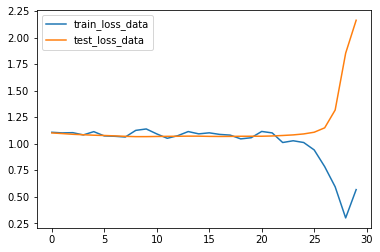

In [9]:
pd.DataFrame(model._history[0]).plot()

In [10]:
model.evaluate(model.get_eval_dataloader(), scoring=btorch.metrics.accuarcy)

{'loss': 2.1643078327178955, 'score': 0.4}

In [11]:
model._optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    names: ['a_a_1.weight', 'a_a_1.bias', 'a_a_2.weight', 'a_a_2.bias']
    nesterov: False
    query: ^a.a.*
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    initial_lr: 0.010000000000000002
    lr: 0.010000000000000002
    maximize: False
    momentum: 0.9
    names: ['a_b_1.weight', 'a_b_1.bias']
    nesterov: False
    query: ^a.*
    weight_decay: 0

Parameter Group 2
    dampening: 0
    foreach: None
    initial_lr: 0.015
    lr: 0.015
    maximize: False
    momentum: 0.9
    names: ['c_a.weight', 'c_1.weight', 'c_2.weight']
    nesterov: False
    query: ^c.*.weight$
    weight_decay: 0

Parameter Group 3
    dampening: 0
    foreach: None
    initial_lr: 0.15000000000000002
    lr: 0.15000000000000002
    maximize: False
    momentum: 0.9
    names: []
    nesterov: False
    query: final
    weight_decay: 0

Parameter

# un_freeze f.bias and refit for 2 epoch

In [12]:
fBias= {'initial_lr': 1,
  'lr': 1,
  'names': ['f.bias'],
  'params': model.f.bias,
}
model._optimizer.add_param_group(fBias)

In [13]:
model.fit(x, y, validation_split=0.3, verbose=0, epoch=2)

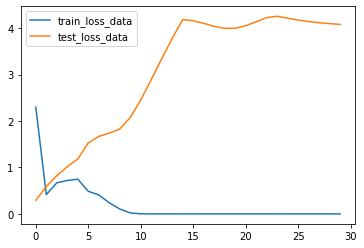

In [14]:
pd.DataFrame(model._history[1]).plot()

In [15]:
model._optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    names: ['a_a_1.weight', 'a_a_1.bias', 'a_a_2.weight', 'a_a_2.bias']
    nesterov: False
    query: ^a.a.*
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    initial_lr: 0.010000000000000002
    lr: 0.010000000000000002
    maximize: False
    momentum: 0.9
    names: ['a_b_1.weight', 'a_b_1.bias']
    nesterov: False
    query: ^a.*
    weight_decay: 0

Parameter Group 2
    dampening: 0
    foreach: None
    initial_lr: 0.015
    lr: 0.015
    maximize: False
    momentum: 0.9
    names: ['c_a.weight', 'c_1.weight', 'c_2.weight']
    nesterov: False
    query: ^c.*.weight$
    weight_decay: 0

Parameter Group 3
    dampening: 0
    foreach: None
    initial_lr: 0.15000000000000002
    lr: 0.15000000000000002
    maximize: False
    momentum: 0.9
    names: []
    nesterov: False
    query: final
    weight_decay: 0

Parameter

# Change the entire param group and refit for 2 epoch

In [16]:
from btorch.utils.trainer import finetune
new_model_params = finetune(model, base_lr=0.05, groups={'^a.a.*': 1, 
                                                      '^a.*': 0.2, 
                                                      '^c.*.weight$': 0.3, 
                                                      '^c.*.bias$': 0.1, 
                                                      'f': 0.1, 
                                                      'final': 3}, regex=True)
model._optimizer = torch.optim.SGD(new_model_params, momentum=0.9)

In [17]:
model.fit(x, y, validation_split=0.3, verbose=0, epoch=2)

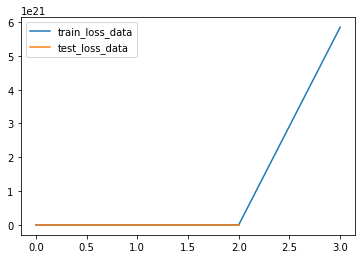

In [18]:
pd.DataFrame(model._history[2]).plot()

In [19]:
model._optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    names: ['a_a_1.weight', 'a_a_1.bias', 'a_a_2.weight', 'a_a_2.bias']
    nesterov: False
    query: ^a.a.*
    weight_decay: 0

Parameter Group 1
    dampening: 0
    foreach: None
    initial_lr: 0.010000000000000002
    lr: 0.010000000000000002
    maximize: False
    momentum: 0.9
    names: ['a_b_1.weight', 'a_b_1.bias']
    nesterov: False
    query: ^a.*
    weight_decay: 0

Parameter Group 2
    dampening: 0
    foreach: None
    initial_lr: 0.015
    lr: 0.015
    maximize: False
    momentum: 0.9
    names: ['c_a.weight', 'c_1.weight', 'c_2.weight']
    nesterov: False
    query: ^c.*.weight$
    weight_decay: 0

Parameter Group 3
    dampening: 0
    foreach: None
    initial_lr: 0.005000000000000001
    lr: 0.005000000000000001
    maximize: False
    momentum: 0.9
    names: ['c_a.bias', 'c_1.bias', 'c_2.bias']
    nesterov: False
    query: 